## Erik Bayerlein - 537606

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error #relative

### Algorithms

#### Auxiliary Algorithms

In [498]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [499]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse_loss(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mre(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

### MLP

In [ ]:
class MLP:
    def __init__(self, max_iter: int = 500, activation: str = 'sigmoid', 
                 hidden_layers: list = [3], learning_rate: float = 0.1, 
                 momentum: float = 0.9, batch_size: int = 32):
        match activation:
            case 'sigmoid':
                self.activation = sigmoid
                self.activation_deriv = sigmoid_derivative
            case _:
                print('Invalid activation function')
                return
        self.max_iter = max_iter
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
        self.v_weights = []
        self.v_biases = []

    def __initialize_weights(self, n_features: int, n_outputs: int):
        layers = [n_features] + self.hidden_layers + [n_outputs]
        for i in range(len(layers) - 1):
            weight = np.random.randn(layers[i], layers[i + 1]) * 0.01
            bias = np.zeros((1, layers[i + 1]))
            
            # initialize momentum velocities
            v_weight = np.zeros_like(weight)
            v_bias = np.zeros_like(bias)
            
            self.weights.append(weight)
            self.biases.append(bias)
            self.v_weights.append(v_weight)
            self.v_biases.append(v_bias)

    def __forward_pass(self, X: np.ndarray):
        activations = [X]
        z_values = []

        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)

            if i < len(self.weights) - 1:
                a = self.activation(z)
            else:
                a = z  # linear output for regression
            activations.append(a)

        return activations, z_values

    def __backward_pass(self, X: np.ndarray, Y: np.ndarray, activations: list):
        m = X.shape[0]
        output_error = activations[-1] - Y
        errors = [output_error]

        # calculate errors for hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            derivative = self.activation_deriv(activations[i + 1])
            error = np.dot(errors[-1], self.weights[i + 1].T) * derivative
            errors.append(error)
        
        errors.reverse()
        
        # update weights and biases with momentum
        for i in range(len(self.weights)):
            dW = np.dot(activations[i].T, errors[i]) / m
            db = np.mean(errors[i], axis=0, keepdims=True)
            
            self.v_weights[i] = self.momentum * self.v_weights[i] + (1 - self.momentum) * dW
            self.v_biases[i] = self.momentum * self.v_biases[i] + (1 - self.momentum) * db

            self.weights[i] -= self.learning_rate * self.v_weights[i]
            self.biases[i] -= self.learning_rate * self.v_biases[i]

    def fit(self, X_train: np.ndarray, Y_train: np.ndarray, 
            X_val = None, Y_val = None):
        self.X_train = X_train
        self.Y_train = Y_train.reshape(-1, 1) if Y_train.ndim == 1 else Y_train

        self.X_val = X_val
        self.Y_val = Y_val
        
        n_features = self.X_train.shape[1]
        n_outputs = 1 if self.Y_train.ndim == 1 else self.Y_train.shape[1]        

        self.__initialize_weights(n_features, n_outputs)
        
        self.loss_history = []
        self.val_loss_history = []
        
        for epoch in range(self.max_iter):
            permutation = np.random.permutation(self.X_train.shape[0])
            X_train_shuffled = self.X_train[permutation]
            Y_train_shuffled = self.Y_train[permutation]
            
            # train on each batch
            for i in range(0, X_train_shuffled.shape[0], self.batch_size):
                X_batch = X_train_shuffled[i:i + self.batch_size]
                Y_batch = Y_train_shuffled[i:i + self.batch_size]

                activations, u = self.__forward_pass(X_batch)
                self.__backward_pass(u, Y_batch, activations)
            
            train_activations, _ = self.__forward_pass(self.X_train)
            train_loss = mse_loss(self.Y_train, train_activations[-1])
            self.loss_history.append(train_loss)
            
            # validation loss
            if self.X_val is not None and self.Y_val is not None:
                val_pred = self.predict(self.X_val)
                val_loss = mse_loss(self.Y_val, val_pred)
                self.val_loss_history.append(val_loss)
            
            if (epoch + 1) % 50 == 0:
                progress = int(50 * (epoch + 1) / self.max_iter)
                bar = "█" * progress + "░" * (50 - progress)
                percentage = 100 * (epoch + 1) / self.max_iter
                if self.X_val is not None:
                    print(f"\r[{bar}] {percentage:.1f}%", end="")
                    print(f' | Epoch {epoch + 1}/{self.max_iter}, Train: {train_loss:.6f}, Val: {self.val_loss_history[-1]:.6f}')
                else:
                    print(f"\r[{bar}] {percentage:.1f}%", end="")
                    print(f' | Epoch {epoch + 1}/{self.max_iter}, Train: {train_loss:.6f}')

    def predict(self, X_test: np.ndarray):
        activations, _ = self.__forward_pass(X_test)
        return activations[-1]

-----------------------------------------------------

## Q1

In [501]:
data = pd.read_csv('../../datasets/concrete.csv')

train_val, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, val = train_test_split(train_val, test_size=0.25, shuffle=True, random_state=0)

### a)

In [502]:
X_train = train.iloc[:, :-1].values
Y_train = train.iloc[:, -1].values

X_val = val.iloc[:, :-1].values
Y_val = val.iloc[:, -1].values

X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

In [503]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [504]:
mlp = MLP(
    max_iter=500, 
    activation='sigmoid', 
    hidden_layers=[5], 
    learning_rate=0.01,
    momentum=0.9,
    batch_size=64
)

In [505]:
mlp.fit(X_train, Y_train, X_val, Y_val)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 64) + inhomogeneous part.

In [ ]:
train_predictions = mlp.predict(X_train)
val_predictions = mlp.predict(X_val)
test_predictions = mlp.predict(X_test)

In [ ]:
final_train_loss = mse_loss(Y_train, train_predictions)
final_val_loss = mse_loss(Y_val, val_predictions)
final_test_loss = mse_loss(y_test, test_predictions)

print("\n" + "="*50)
print("FINAL RESULTS:")
print("="*50)
print(f"Final Train Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Final Test Loss: {final_test_loss:.6f}")


FINAL RESULTS:
Final Train Loss: 532.148199
Final Validation Loss: 507.374909
Final Test Loss: 450.362837


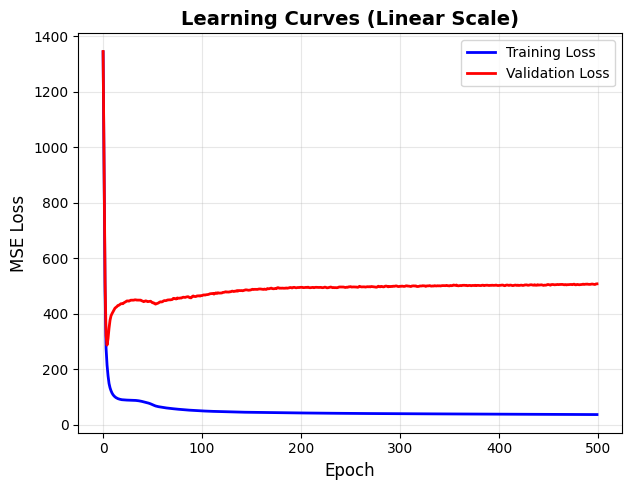

In [ ]:
plt.figure(figsize=(12, 5))

# Plot 2: Training and Validation Loss (Linear Scale)
plt.subplot(1, 2, 2)
plt.plot(mlp.loss_history, label='Training Loss', linewidth=2, color='blue')
plt.plot(mlp.val_loss_history, label='Validation Loss', linewidth=2, color='red')
plt.title('Learning Curves (Linear Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
rmse_train = rmse(Y_train, train_predictions)
rmse_val = rmse(Y_val, val_predictions)
rmse_test = rmse(y_test, test_predictions)

mae_train = mae(Y_train, train_predictions)
mae_val = mae(Y_val, val_predictions)
mae_test = mae(y_test, test_predictions)

print("\nDETAILED METRICS:")
print("-"*30)
print(f"Train - MSE: {final_train_loss:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")
print(f"Val   - MSE: {final_val_loss:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test  - MSE: {final_test_loss:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")


DETAILED METRICS:
------------------------------
Train - MSE: 532.1482, RMSE: 23.0683, MAE: 18.6046
Val   - MSE: 507.3749, RMSE: 22.5250, MAE: 18.0480
Test  - MSE: 450.3628, RMSE: 21.2218, MAE: 17.0024


### b)

## Q2

In [ ]:
data = pd.read_csv('../../datasets/vowel.csv')

train_val, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, val = train_test_split(train_val, test_size=0.25, shuffle=True, random_state=0)

### a)

### b)